In [1]:
# ================== 1. 读数据 & 初步检查 ==================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 6 张交易表
pre_owned     = pd.read_csv("train/pre_owned_house_transactions.csv")
pre_owned_nb  = pd.read_csv("train/pre_owned_house_transactions_nearby_sectors.csv")
land          = pd.read_csv("train/land_transactions.csv")
land_nb       = pd.read_csv("train/land_transactions_nearby_sectors.csv")
new_house     = pd.read_csv("train/new_house_transactions.csv")
new_house_nb  = pd.read_csv("train/new_house_transactions_nearby_sectors.csv")

# 其他表
poi          = pd.read_csv("train/sector_POI.csv")
search_index = pd.read_csv("train/city_search_index.csv")
city_idx     = pd.read_csv("train/city_indexes.csv")

print("pre_owned.shape    =", pre_owned.shape)
print("pre_owned_nb.shape =", pre_owned_nb.shape)
print("land.shape         =", land.shape)
print("land_nb.shape      =", land_nb.shape)
print("new_house.shape    =", new_house.shape)
print("new_house_nb.shape =", new_house_nb.shape)
print("city_idx.shape     =", city_idx.shape)
print("poi.shape          =", poi.shape)
print("search_index.shape =", search_index.shape)


pre_owned.shape    = (5360, 6)
pre_owned_nb.shape = (5427, 6)
land.shape         = (5896, 6)
land_nb.shape      = (5025, 6)
new_house.shape    = (5433, 11)
new_house_nb.shape = (5360, 11)
city_idx.shape     = (7, 74)
poi.shape          = (86, 142)
search_index.shape = (4020, 4)


In [2]:
# ================== 2. 清洗 6 张交易表（保证 month+sector 唯一） ==================

def clean_tx(df: pd.DataFrame, name: str) -> pd.DataFrame:
    df = df.copy()
    # 去掉列名空格
    df.columns = [c.strip() for c in df.columns]
    
    # 检查 (month, sector) 是否唯一
    if not set(['month', 'sector']).issubset(df.columns):
        raise ValueError(f"[{name}] 缺少 month 或 sector 列，请检查原始 CSV 列名。")
    
    dup_mask = df.duplicated(subset=['month', 'sector'], keep=False)
    dup_count = dup_mask.sum()
    if dup_count > 0:
        print(f"[{name}] 在 (month, sector) 上有 {dup_count} 行重复，将按数值列求和聚合。")
        num_cols = df.select_dtypes(include='number').columns
        df = df.groupby(['month', 'sector'], as_index=False)[num_cols].sum()
    else:
        print(f"[{name}] 在 (month, sector) 上没有重复。")
    
    return df

pre_owned    = clean_tx(pre_owned,    "pre_owned")
pre_owned_nb = clean_tx(pre_owned_nb, "pre_owned_nb")
land         = clean_tx(land,         "land")
land_nb      = clean_tx(land_nb,      "land_nb")
new_house    = clean_tx(new_house,    "new_house")
new_house_nb = clean_tx(new_house_nb, "new_house_nb")


[pre_owned] 在 (month, sector) 上没有重复。
[pre_owned_nb] 在 (month, sector) 上没有重复。
[land] 在 (month, sector) 上没有重复。
[land_nb] 在 (month, sector) 上没有重复。
[new_house] 在 (month, sector) 上没有重复。
[new_house_nb] 在 (month, sector) 上没有重复。


In [3]:
# ================== 3. 构建 master：month×sector 网格 + 目标列 + 6 张交易表 ==================

# (1) 完整的 (month, sector) 主键网格
all_pairs = pd.concat([
    pre_owned[['month','sector']],
    pre_owned_nb[['month','sector']],
    land[['month','sector']],
    land_nb[['month','sector']],
    new_house[['month','sector']],
    new_house_nb[['month','sector']]
]).drop_duplicates().reset_index(drop=True)

print("all_pairs 行数：", len(all_pairs))
display(all_pairs.head())

# (2) 加上目标列 amount_new_house_transactions
if 'amount_new_house_transactions' not in new_house.columns:
    raise ValueError("new_house 表中没有 'amount_new_house_transactions' 列，请检查原始文件。")

master = all_pairs.merge(
    new_house[['month','sector','amount_new_house_transactions']],
    on=['month','sector'],
    how='left'
)

print("master 初始形状（只含目标列）:", master.shape)
print("master 中目标列缺失行数：",
      master['amount_new_house_transactions'].isna().sum())

# (3) 合并其他 5 张交易表（左连接）
# 注意：suffixes 防止同名列冲突，后续可以再精简列
master = master.merge(pre_owned,    on=['month', 'sector'], how='left', suffixes=('', '_pre'))
master = master.merge(pre_owned_nb, on=['month', 'sector'], how='left', suffixes=('', '_pre_nb'))
master = master.merge(land,         on=['month', 'sector'], how='left', suffixes=('', '_land'))
master = master.merge(land_nb,      on=['month', 'sector'], how='left', suffixes=('', '_land_nb'))
master = master.merge(new_house_nb, on=['month', 'sector'], how='left', suffixes=('', '_nh_nb'))

print("master 合并 6 张交易表后的形状：", master.shape)

# 再次检查 (month, sector) 唯一性
dup_master = master.duplicated(subset=['month', 'sector'], keep=False)
print("master 中 (month, sector) 重复行数：", dup_master.sum())


all_pairs 行数： 6432


,month,sector
0,2019-Jan,sector 35
1,2019-Jan,sector 23
2,2019-Jan,sector 80
3,2019-Jan,sector 53
4,2019-Jan,sector 84


master 初始形状（只含目标列）: (6432, 3)
master 中目标列缺失行数： 999
master 合并 6 张交易表后的形状： (6432, 28)
master 中 (month, sector) 重复行数： 0


In [4]:
# ================== 4. 清洗 city_indexes，并展开成按月表 ==================

city_idx = city_idx.copy()

# 如果你确认最后一行是重复的 2022，可以删掉；否则注释掉下一行
city_idx = city_idx.drop(city_idx.tail(1).index)

# 去重
city_idx = city_idx.drop_duplicates()

# 删除全 NaN 的列
city_idx = city_idx.loc[:, city_idx.notna().any(axis=0)]

print("city_idx 清洗后形状：", city_idx.shape)
display(city_idx.head())

# 查看缺失情况（这里只是看看，不立即丢列）
missing_counts_city_idx = city_idx.isna().sum()
missing_counts_city_idx = missing_counts_city_idx[missing_counts_city_idx > 0].sort_values(ascending=False)
print("city_idx 中有缺失的列：")
display(missing_counts_city_idx)

# 按年展开成每个月（YYYY-MMM），先不对缺失值做插值，保持原始信息
if 'city_indicator_data_year' not in city_idx.columns:
    raise ValueError("city_idx 中没有 'city_indicator_data_year' 列，请检查 city_indexes.csv。")

city_idx_full = city_idx.copy()

# 生成 YYYY-MMM 格式的 month（与交易表的 month 对齐）
all_months = []
for _, row in city_idx_full.iterrows():
    year = int(row['city_indicator_data_year'])
    for m in range(1, 13):
        month_str = f"{year}-{pd.Timestamp(year, m, 1).strftime('%b')}"  # 例如 2017-Jan
        data = row.drop(labels=['city_indicator_data_year']).to_dict()
        data['month'] = month_str
        all_months.append(data)

city_idx_month = pd.DataFrame(all_months)

print("city_idx_month 形状：", city_idx_month.shape)
display(city_idx_month.head())


city_idx 清洗后形状： (6, 73)


,city_indicator_data_year,year_end_registered_population_10k,total_households_10k,year_end_resident_population_10k,year_end_total_employed_population_10k,year_end_urban_non_private_employees_10k,private_individual_and_other_employees_10k,private_individual_ratio,national_year_end_total_population_10k,resident_registered_ratio,...,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,total_fixed_assets_10k,main_business_taxes_and_surcharges_10k,real_estate_development_investment_completed_10k,residential_development_investment_completed_10k,science_expenditure_10k,education_expenditure_10k
0,2017,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008,1.614755,...,521.52,0.580841,4664,96779199,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0
1,2018,927.69,305.9851,1490.44,1102.36,348.65,753.7146,0.683728,139538,1.606614,...,544.17,0.586586,4675,99067099,NaN,4297060.0,27019323.0,17466618.0,1636655.0,4408209.0
2,2019,953.72,313.8455,1530.59,1125.89,400.22,725.6720,0.644532,140005,1.604863,...,565.83,0.593287,5804,110643480,39934058.0,4862051.0,31022573.0,20870742.0,2439456.0,5239743.0
3,2020,985.11,322.1068,1874.03,1158.01,419.36,738.6462,0.637858,141212,1.902356,...,619.78,0.629148,6208,123664111,NaN,NaN,NaN,NaN,2241321.0,5585916.0
4,2021,1011.53,329.7224,1881.06,1163.44,426.94,736.5017,0.633038,141260,1.859619,...,694.68,0.686762,6757,142064810,NaN,NaN,NaN,NaN,2012478.0,5890857.0


city_idx 中有缺失的列：


total_fixed_assets_10k                              4
main_business_taxes_and_surcharges_10k              3
real_estate_development_investment_completed_10k    3
residential_development_investment_completed_10k    3
dtype: int64

city_idx_month 形状： (72, 73)


,year_end_registered_population_10k,total_households_10k,year_end_resident_population_10k,year_end_total_employed_population_10k,year_end_urban_non_private_employees_10k,private_individual_and_other_employees_10k,private_individual_ratio,national_year_end_total_population_10k,resident_registered_ratio,under_18_10k,...,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,total_fixed_assets_10k,main_business_taxes_and_surcharges_10k,real_estate_development_investment_completed_10k,residential_development_investment_completed_10k,science_expenditure_10k,education_expenditure_10k,month
0,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008.0,1.614755,171.4642,...,0.580841,4664.0,96779199.0,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0,2017-Jan
1,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008.0,1.614755,171.4642,...,0.580841,4664.0,96779199.0,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0,2017-Feb
2,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008.0,1.614755,171.4642,...,0.580841,4664.0,96779199.0,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0,2017-Mar
3,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008.0,1.614755,171.4642,...,0.580841,4664.0,96779199.0,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0,2017-Apr
4,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008.0,1.614755,171.4642,...,0.580841,4664.0,96779199.0,39013240.0,4012517.0,27028935.0,17694861.0,1712569.0,4043335.0,2017-May


In [5]:
# ================== 5. 合并 city 指标到 master，生成 df ==================

# 先把 month 保持为字符串（后面统一转为 datetime）
master = master.copy()

# 合并 city_idx_month：同一年的指标复制到该年的每个月
master = master.merge(city_idx_month, on='month', how='left', suffixes=('', '_idx'))
print("合并 city_idx_month 后 master 形状：", master.shape)

# （可选）合并 search_index，如果它有 month 列
if 'month' in search_index.columns:
    master = master.merge(search_index, on='month', how='left', suffixes=('', '_search'))
    print("合并 search_index 后 master 形状：", master.shape)
else:
    print("search_index 中没有 month 列，暂时跳过合并。")

# （可选）合并 poi，如果它按 sector 静态给指标
if 'sector' in poi.columns:
    master = master.merge(poi, on='sector', how='left', suffixes=('', '_poi'))
    print("合并 poi 后 master 形状：", master.shape)
else:
    print("poi 中没有 sector 列，暂时跳过合并。")

# 建模主表
df = master.copy()
print("df 初始形状：", df.shape)


合并 city_idx_month 后 master 形状： (6432, 100)
合并 search_index 后 master 形状： (385920, 103)
合并 poi 后 master 形状： (385920, 244)
df 初始形状： (385920, 244)


类型统一 & 去重后的 df 形状： (385920, 234)


,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,medical_health_rehabilitation_institution_dense,medical_health_first_aid_center_dense,medical_health_blood_donation_station_dense,medical_health_disease_prevention_institution_dense,medical_health_general_hospital_dense,medical_health_clinic_dense,education_training_school_education_middle_school_dense,education_training_school_education_primary_school_dense,education_training_school_education_kindergarten_dense,education_training_school_education_research_institution_dense
0,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,0.000113,0.0,0.0,8.600000e-07,0.000041,0.000038,0.000016,0.000028,0.000063,0.000014
1,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,0.000113,0.0,0.0,8.600000e-07,0.000041,0.000038,0.000016,0.000028,0.000063,0.000014
2,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,0.000113,0.0,0.0,8.600000e-07,0.000041,0.000038,0.000016,0.000028,0.000063,0.000014
3,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,0.000113,0.0,0.0,8.600000e-07,0.000041,0.000038,0.000016,0.000028,0.000063,0.000014
4,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.75,733.0,1247.038,...,0.000113,0.0,0.0,8.600000e-07,0.000041,0.000038,0.000016,0.000028,0.000063,0.000014


df 中缺失值列统计（只显示有缺失的列）：


total_fixed_assets_10k                                            316800
real_estate_development_investment_completed_10k                  316800
residential_development_investment_completed_10k                  316800
main_business_taxes_and_surcharges_10k                            316800
national_year_end_total_population_10k                            109440
                                                                   ...  
education_training_school_education_research_institution_dense     40200
num_land_transactions                                              32160
construction_area                                                  32160
planned_building_area                                              32160
transaction_amount                                                 32160
Length: 229, dtype: int64

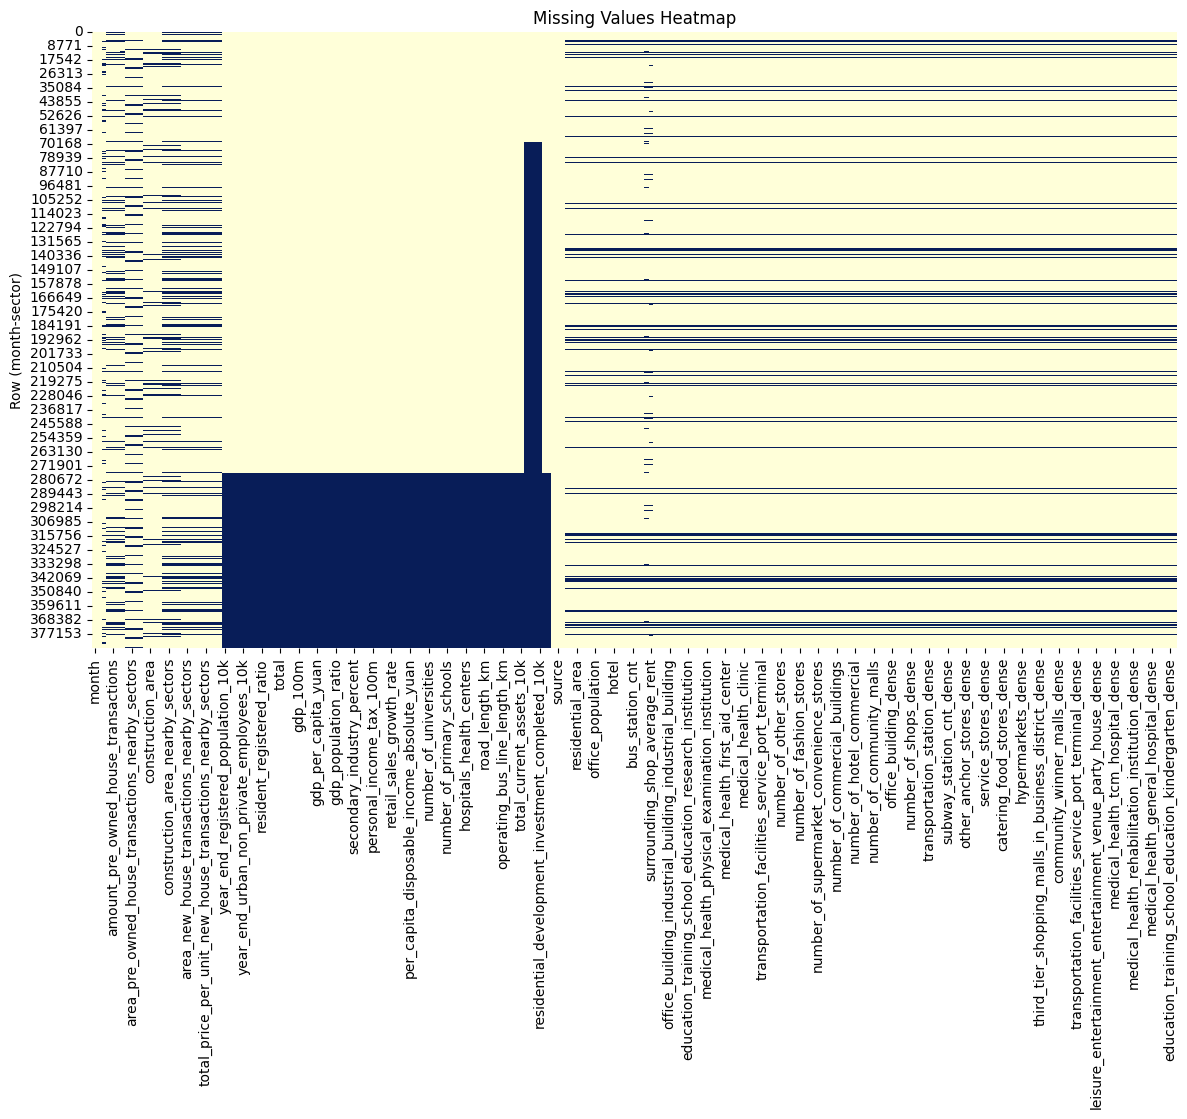

In [6]:
# ================== 6. 统一类型、去重、检查缺失 ==================

# 1) month 转为 datetime（只保留年月）
# 如果 month 已经是 datetime，可适当调整 format
df['month'] = pd.to_datetime(df['month'], format='%Y-%b')

# 2) sector：如果是 'sector 1' 形式，提取数字
if df['sector'].dtype == 'object':
    df['sector'] = df['sector'].str.extract(r'(\d+)').astype(int)

# 3) 按 (month, sector) 排序
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# 4) 删除重复行
df = df.drop_duplicates()

# 5) 删除完全重复的列
df = df.loc[:, ~df.T.duplicated()]

print("类型统一 & 去重后的 df 形状：", df.shape)
display(df.head())

# 缺失总体情况
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("df 中缺失值列统计（只显示有缺失的列）：")
display(missing_counts)

# 缺失热力图（可以留在单独一个 cell）
plt.figure(figsize=(14, 8))
sns.heatmap(df.isna(), cbar=False, cmap="YlGnBu")
plt.ylabel("Row (month-sector)")
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# ================== 7. 按类型处理缺失值（不再全表 ffill，不动目标列） ==================

target_col = "amount_new_house_transactions"

# 1) 宏观时间序列类特征：来自 city_idx / search_index
macro_cols = [c for c in df.columns 
              if c.startswith("city_") or c.startswith("search_")]

# 2) 计数/金额类特征：num_ / amount_ / area_ 开头（除目标以外）
count_cols = [c for c in df.columns 
              if (("num_" in c) or ("amount_" in c) or ("area_" in c))]
count_cols = [c for c in count_cols if c != target_col]

# 3) 其他数值特征
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
other_num_cols = [c for c in num_cols_all 
                  if c not in macro_cols + count_cols + [target_col]]

print("宏观特征列数：", len(macro_cols))
print("计数/金额特征列数：", len(count_cols))
print("其他数值特征列数：", len(other_num_cols))

# ---- 1) 宏观特征：按 sector + 时间排序后做 ffill + bfill ----
df = df.sort_values(["sector", "month"])
for col in macro_cols:
    df[col] = df.groupby("sector")[col].transform(lambda s: s.ffill().bfill())

# ---- 2) 计数/金额类：缺失多半表示“当月没有发生”，可默认填 0（不含目标） ----
if count_cols:
    df[count_cols] = df[count_cols].fillna(0)

# ---- 3) 剩余数值特征：用中位数填补 ----
if other_num_cols:
    df[other_num_cols] = df[other_num_cols].fillna(df[other_num_cols].median())

# 注意：目标列暂时不动，留给后面建模时决定是删掉还是当 0
print("目标列缺失行数（保留）：", df[target_col].isna().sum())

print("预处理后的 df 形状：", df.shape)
df.info()


宏观特征列数： 2
计数/金额特征列数： 22
其他数值特征列数： 206
目标列缺失行数（保留）： 59940
预处理后的 df 形状： (385920, 234)
<class 'pandas.core.frame.DataFrame'>
Index: 385920 entries, 0 to 385919
Columns: 234 entries, month to education_training_school_education_research_institution_dense
dtypes: datetime64[ns](1), float64(229), int64(2), object(2)
memory usage: 691.9+ MB
